Incorporating amino acid starvation promoted tRNA degradation

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

In [4]:
plt.rcParams.update({'font.size': 22})

In [64]:
def iteration(plasmids, cycA, tRNA, alanyl_tRNA, intra_alanine, synthetase, masp, transcription_rate, base_uptake, k_cat, decay_factor, decay_state, tRNA_on, cycA_on, synthetase_on):
    if tRNA_on == True:
        tRNA += ((transcription_rate*plasmids)/76) #length of alanine tRNA = 76 base pairs
    if cycA_on == True:
        cycA += ((transcription_rate*plasmids)/1413) #length of cycA mRNA = 1413 base pairs, translation coupled to transcription
    if synthetase_on == True:
        synthetase += ((transcription_rate*plasmids)/2628)
    
    intra_alanine += (base_uptake + k_cat * cycA)
    #Aminoacylation step
    if tRNA <= synthetase * 2.0 and tRNA <= intra_alanine: #if tRNA availability is limiting factor
        decay_counter = 0
        alanyl_tRNA += tRNA
        intra_alanine -= tRNA
        tRNA = 0
    elif intra_alanine <= tRNA and intra_alanine <= synthetase * 2.0: #if alanine is limiting factor 
        alanyl_tRNA += intra_alanine
        if decay_state == True:
            #tRNA = tRNA*np.exp(-decay_factor) #exponential decay factor
            tRNA = tRNA * decay_factor #linear decay factor
        tRNA -= intra_alanine
        intra_alanine = 0
    else: #if synthetase is limiting factor
        decay_counter = 0
        alanyl_tRNA += synthetase * 2.0
        intra_alanine -= synthetase * 2.0
        tRNA -= synthetase * 2.0
    
    #Translation step
    masp += alanyl_tRNA / 80
    tRNA += alanyl_tRNA
    alanyl_tRNA = 0
    
    return(cycA, tRNA, intra_alanine, alanyl_tRNA, synthetase, masp)

In [69]:
def yield_over_time(plasmids, cycA, tRNA, intra_alanine, alanyl_tRNA, synthetase, masp, transcription_rate, base_uptake, k_cat, decay_factor, decay_state, tRNA_on, cycA_on, synthetase_on, num_iterations):
    masp_values = [masp]
    alanine_values = [intra_alanine]
    tRNA_values = [tRNA]
    cycA_values = [cycA]
    for i in range(num_iterations):
        cycA, tRNA, intra_alanine, alanyl_tRNA, synthetase, masp = iteration(plasmids, cycA, tRNA, alanyl_tRNA, intra_alanine, synthetase, masp, transcription_rate, base_uptake, k_cat, decay_factor, decay_state, tRNA_on, cycA_on, synthetase_on)
        alanine_values.append(intra_alanine)
        masp_values.append(masp)
        tRNA_values.append(tRNA)
        cycA_values.append(cycA)
    
    return([alanine_values, masp_values, tRNA_values, cycA_values])

In [93]:
def tRNAvsAlanineplotter(plasmids, cycA, tRNA, intra_alanine, alanyl_tRNA, synthetase, masp, transcription_rate, base_uptake, k_cat, decay_factor, decay_state, tRNA_on, cycA_on, synthetase_on, num_iterations):
    iteration_index = np.arange(num_iterations+1)
    dummy = yield_over_time(plasmids, cycA, tRNA, intra_alanine, alanyl_tRNA, synthetase, masp, transcription_rate, base_uptake, k_cat, decay_factor, decay_state, tRNA_on, cycA_on, synthetase_on, num_iterations)
    alanine_values = dummy[0]
    masp_values = dummy[1]
    tRNA_values = dummy[2]
    cycA_values = dummy[3]
#     for i in range(len(alanine_values)):
#         if alanine_values[i] == 0:
#             alanine_values[i] = 'NaN'
    plt.figure(figsize=(10,10))
    plt.plot(iteration_index, alanine_values)
    plt.plot(iteration_index, masp_values)
    plt.plot(iteration_index, tRNA_values)
    plt.plot(iteration_index, cycA_values)
    plt.yscale('symlog')
    plt.xlabel('Time/s')
    plt.ylabel('Concentration of species/log(molecules/cell)')
    plt.legend(['Alanine', 'MaSp', 'tRNA', 'cycA'])
    plt.title('Concentration of biomolecules over time with tRNA degradation')
    plt.axvline(9800, color = 'k', ls = 'dashed')
    #plt.savefig('./Figures/tRNADegradationSynthetaseOff.png', bbox_inches='tight')
    return(alanine_values)

CPU times: user 43.2 ms, sys: 3.09 ms, total: 46.3 ms
Wall time: 45.9 ms


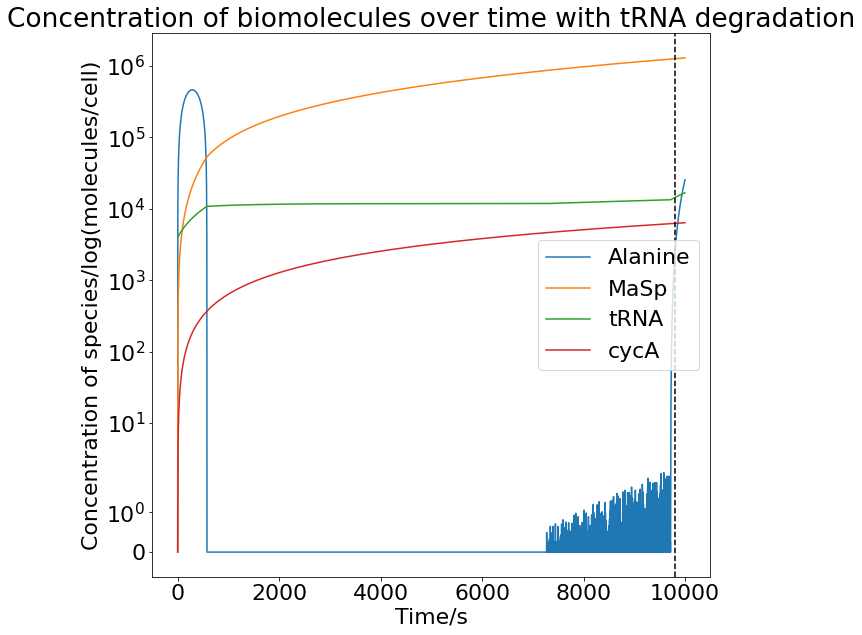

In [112]:
%%time
a = tRNAvsAlanineplotter(plasmids=20, cycA=0, tRNA=4000, intra_alanine=0, alanyl_tRNA=0, synthetase=6695, masp=0, transcription_rate=45, base_uptake=7230, k_cat=0.9953, decay_factor=0.999, decay_state=True, tRNA_on=True, cycA_on=True, synthetase_on=False, num_iterations=10000)

In [89]:
def MaSpDifferentialPlotter(plasmids, cycA, tRNA, intra_alanine, alanyl_tRNA, synthetase, masp, transcription_rate, base_uptake, k_cat, decay_factor, tRNA_on, cycA_on, synthetase_on, num_iterations):
    iteration_index = np.arange(num_iterations+1)
    dummy1 = yield_over_time(plasmids, cycA, tRNA, intra_alanine, alanyl_tRNA, synthetase, masp, transcription_rate, base_uptake, k_cat, decay_factor, True, tRNA_on, cycA_on, synthetase_on, num_iterations)
    dummy2 = yield_over_time(plasmids, cycA, tRNA, intra_alanine, alanyl_tRNA, synthetase, masp, transcription_rate, base_uptake, k_cat, decay_factor, False, tRNA_on, cycA_on, synthetase_on, num_iterations)
    MaSpYield1 = dummy1[1]
    MaSpYield2 = dummy2[1]
    plt.figure(figsize=(10,10))
    plt.plot(iteration_index, MaSpYield1)
    plt.plot(iteration_index, MaSpYield2)
    plt.legend(['tRNA degradation', 'No tRNA degradation'])
    plt.title('MaSp yield over time with and without tRNA degradation modelled')
    plt.ylabel('Concentration of molecules/log(molecules/cell)')
    plt.xlabel('Time/seconds')

CPU times: user 161 ms, sys: 11 ms, total: 172 ms
Wall time: 177 ms


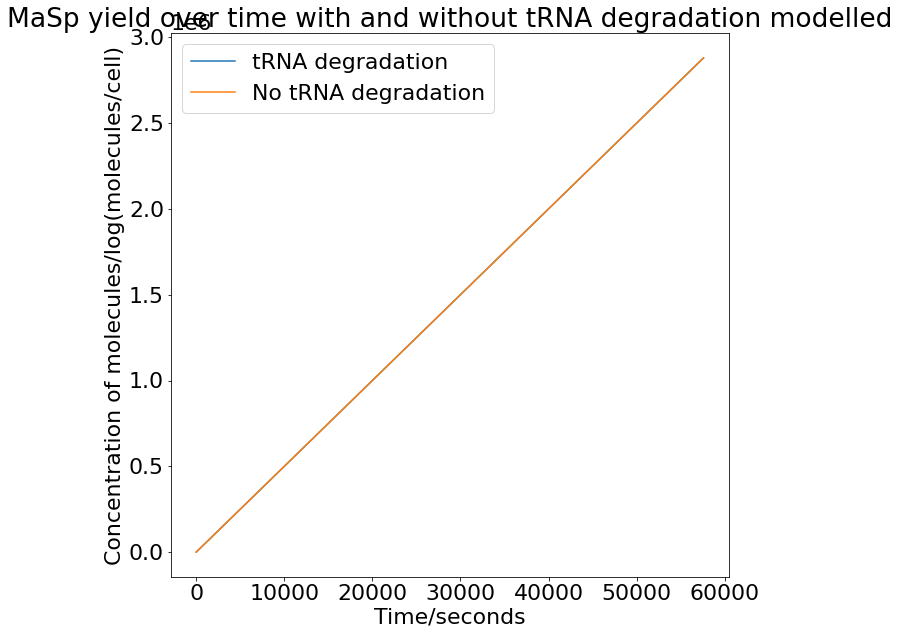

In [92]:
%%time
MaSpDifferentialPlotter(plasmids=20, cycA=0, tRNA=4000, intra_alanine=0, alanyl_tRNA=0, synthetase=6695, masp=0, transcription_rate=45, base_uptake=7230, k_cat=0.9953, decay_factor=0.5, tRNA_on=False, cycA_on=True, synthetase_on=True, num_iterations=57600)